In [18]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import wave
import librosa
from scipy.io import wavfile
from typing import Union, Optional

In [19]:
import sys
sys.path.append('/Users/jaewone/developer/tensorflow/baby-cry-classification')

from utils.sound import *
from utils.os import *
from constant.os import *

In [20]:
df = pd.read_csv(csv_path, index_col=0)
df.tail(1)

,state,gender,age,source,file,detail,duration
3687,uncomfortable,NaN,NaN,iFLYTEK,uncomfortable_121.wav,NaN,15.53


In [21]:
# state에 따른 파일의 개수 확인
count_by_state = df[['state', 'file']].groupby('state').count().reset_index()
count_by_state = count_by_state.sort_values('file', ascending=False)
count_by_state.T

,14,12,11,0,16,18,6,10,15,4,17,7,1,9,3,5,2,13,8
state,sad,hungry,hug,awake,sleepy,uncomfortable,diaper,happy,silence,calm,tired,discomfort,belly_pain,fearful,burping,ch,bored,pain,disgust
file,1180,678,315,280,277,266,248,218,102,30,24,20,16,10,8,7,6,2,1


In [22]:
use_state_list = count_by_state['state'].tolist()[:7]
use_state_list

['sad', 'hungry', 'hug', 'awake', 'sleepy', 'uncomfortable', 'diaper']

In [23]:
# 위 7개 state를 가지는 행만을 가져온다.
use_df = df[df['state'].isin(use_state_list)]

# 총 시간을 확인해 보았을 때도 파일의 개수 순서와 동일한 것을 확인할 수 있다.
use_df[['state', 'duration']].groupby('state').sum().reset_index().pipe(
    lambda df: df.sort_values('duration', ascending=False)).T

,4,3,2,0,5,6,1
state,sad,hungry,hug,awake,sleepy,uncomfortable,diaper
duration,9275.78,7406.107941,5224.674616,4537.685443,4311.109309,4012.536486,3801.370187


In [24]:
# 분석에 사용할 수 없는 데이터는 제외한다.
from trans_data import get_sample_rate

# 음성의 sample rate를 추출한 origin_sample_rate 열을 추가한다.
# 에러가 난 파일은 na 값을 가진다.
use_df = use_df.assign(origin_sample_rate=use_df['file'].apply(
    lambda file: get_sample_rate(os.path.join(data_path, file))))

is_error = use_df.origin_sample_rate.isna()

print(f'전체 {len(use_df)}개의 데이터 중 사용할 수 없는 {(len(use_df[is_error]))}개의 데이터가 제외되었다.')

print(f'제외된 state는: {use_df[is_error].state.values.tolist()} 이다.')

use_df = use_df[is_error == False]

전체 3244개의 데이터 중 사용할 수 없는 6개의 데이터가 제외되었다.
제외된 state는: ['hug', 'sleepy', 'diaper', 'uncomfortable', 'uncomfortable', 'awake'] 이다.


In [25]:
have_to_resample_df = use_df[use_df['origin_sample_rate'] != 16000.0].reset_index(drop=True)
have_to_resample_df.tail(3)

,state,gender,age,source,file,detail,duration,origin_sample_rate
724,uncomfortable,NaN,NaN,iFLYTEK,uncomfortable_26.wav,NaN,16.782222,44100.0
725,uncomfortable,NaN,NaN,iFLYTEK,uncomfortable_109.wav,NaN,16.782222,44100.0
726,uncomfortable,NaN,NaN,iFLYTEK,uncomfortable_135.wav,NaN,13.100567,44100.0


In [26]:
# Copy files to test resampling
file_list = have_to_resample_df['file'].tolist()

test_path = os.path.join(main_path, 'test')
if os.path.exists(test_path):
    remove_path_with_files(test_path)
os.mkdir(test_path)

for file in file_list:
    copy_file(os.path.join(data_path, file), os.path.join(test_path, file))
print("Done")

print(len(os.listdir(test_path)))

Done
727


In [27]:
# 일단 모델에 학습할 수 있는 데이터 추출을 위해 sample rate가 16000이 아는 데이터는 제외한다.

origin_len = len(use_df)
use_df = use_df[use_df['origin_sample_rate'] == 16000.0]

print(f'전체 {origin_len}개의 데이터 중 {origin_len - len(use_df)}개의 데이터가 제외되었다.')
print(f'전체의 {((origin_len - len(use_df)) / origin_len) * 100:.2f}%의 데이터가 제외되었다.')

전체 3238개의 데이터 중 727개의 데이터가 제외되었다.
전체의 22.45%의 데이터가 제외되었다.


In [28]:
# 현재 남아있는 파일의 개수를 확인해보자.
use_df[['state', 'file']].groupby('state').count().T

state,awake,diaper,hug,hungry,sad,sleepy,uncomfortable
file,271,174,284,279,1180,226,97


state           awake      diaper          hug       hungry      sad  \
duration  4367.330563  2705.06225  4741.343187  4493.299687  9275.78   

state          sleepy  uncomfortable  
duration  3521.177563    1528.145125  


<Axes: xlabel='count', ylabel='duration'>

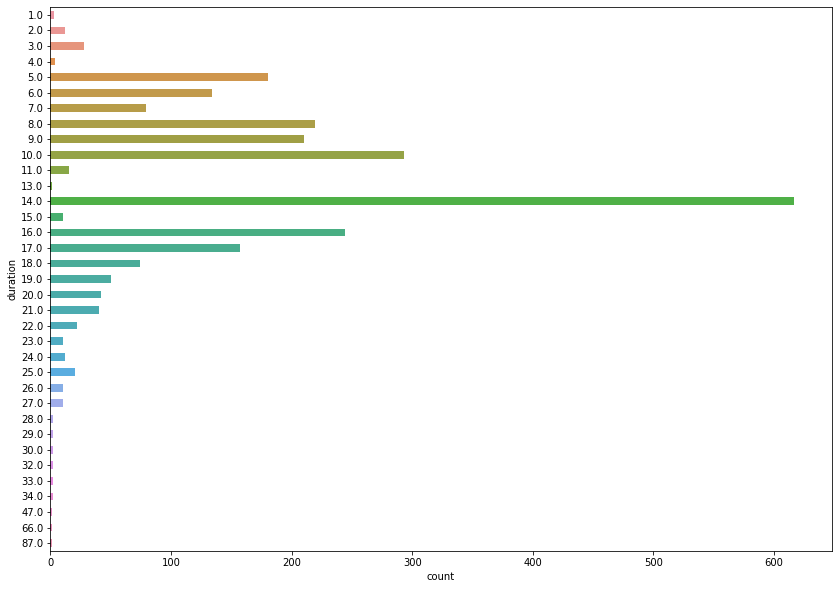

In [29]:
# 상태에 따른 시간을 확인해보자.
print(use_df[['state', 'duration']].groupby('state').sum().T)


# 소수점 내림을 통해 더 자세히 알아보자
fig, ax = plt.subplots(figsize=(14, 10))
sns.countplot(y='duration', 
              data=pd.DataFrame(use_df['duration'].apply(np.ceil)),
              width=0.5)

In [30]:
# 10초 이상 이를 가지는 음성 각 상태에 따른 무작위 파일 100개를 선정한다.
# uncomfortable은 최대 개수인 97개를 선정한다.

use_df = use_df[use_df['duration'] > 8]

# 상태에 따른 시간을 확인해보자.
print(use_df[['state', 'file']].groupby('state').count().T)


# uncomfortable에 해당하는 행은 따로 뺀 뒤
uncomfortable_df = use_df[use_df['state'] == 'uncomfortable']
sample_df = use_df[use_df['state'] != 'uncomfortable']


# 무작위로 100개의 행 씩 추출한다.
sample_df = sample_df.groupby('state').apply(lambda x: x.sample(n=100, random_state=42))

# 다음에 빼두었던 uncomfortable 행들을 합쳐준다. 전체 697개의 데이터가 있음을 확인할 수 있다.
sample_df = pd.concat([sample_df, uncomfortable_df]).reset_index(drop=True)
sample_df.tail(5)

state  awake  diaper  hug  hungry  sad  sleepy  uncomfortable
file     271     172  284     279  523     226             97


,state,gender,age,source,file,detail,duration,origin_sample_rate
692,uncomfortable,NaN,NaN,iFLYTEK,uncomfortable_21.wav,NaN,15.510938,16000.0
693,uncomfortable,NaN,NaN,iFLYTEK,uncomfortable_123.wav,NaN,15.499313,16000.0
694,uncomfortable,NaN,NaN,iFLYTEK,uncomfortable_134.wav,NaN,15.510875,16000.0
695,uncomfortable,NaN,NaN,iFLYTEK,uncomfortable_33.wav,NaN,16.253250,16000.0
696,uncomfortable,NaN,NaN,iFLYTEK,uncomfortable_121.wav,NaN,15.530000,16000.0


In [31]:
# 각 파일의 2초부터 7초 사이의 음성을 추출한다.
# 지금은 간단하게 하나의 파일에서 하나의 데이터셋을 추출하였으나 차후에는 다중 추출을 진행하자.


def split_audios(file_list, from_path, to_path, start_time, end_time):
    
    # to_path 경로(폴더)가 없을 경우 생성한다.
    if not os.path.exists(to_path):
        os.makedirs(to_path)

    for file in file_list:
        
        # 파일의 정보를 읽어온다.
        y, sr = librosa.load(os.path.join(from_path, file), sr=None)

        # 음성 자르기
        start_sample = int(start_time * sr)
        end_sample = int(end_time * sr)
        segmented_audio = y[start_sample:end_sample]

        # 저장
        segmented_audio = np.array(segmented_audio * (2**15), dtype=np.int16)
        wavfile.write(os.path.join(to_path, file), sr, segmented_audio)

split_audios(
    file_list=sample_df['file'].tolist(),
    from_path=data_path,
    to_path = os.path.join(main_path, 'sample_data'),
    start_time=2,
    end_time=7
)

In [32]:
failed_list = [file for file in sample_df['file'].tolist() if file not in os.listdir(os.path.join(main_path, 'sample_data'))]

for file in failed_list:
    print(file)

In [33]:
print(len(sample_df['file'].tolist()))
print(len(os.listdir(os.path.join(main_path,'sample_data'))))

697
697


In [34]:
# 위 정보를 반영하여 csv로 저장한다.

sample_df['duration'] = 5
sample_df.to_csv(os.path.join(main_path, 'sample_data.csv'))
print(f'Save csv: ' + os.path.join(main_path, 'sample_data.csv'))

Save csv: /Users/jaewone/developer/tensorflow/baby-cry-classification/sample_data.csv
